# **HMM Baseline Model (Time-Series) - Sprint 2 CA2**

### *Objective*
Train a baseline **Hidden Markov Model (HMM)** for trip safety prediction using time-series sensor data.

We will:
1. Load the prepared time-series dataset from `Datasets/time_series_data/`
2. Build sequences (one sequence per `bookingID`)
3. Train **two Gaussian HMMs**:
   - `HMM_safe` trained on trips where `is_dangerous_trip = 0`
   - `HMM_danger` trained on trips where `is_dangerous_trip = 1`
4. Predict a trip label by comparing log-likelihoods:
   - if `logP(X | HMM_danger) > logP(X | HMM_safe)` => predict dangerous (1)
5. Evaluate performance and log experiments using **MLflow**
6. Save model artifacts for later use in the Tkinter GUI

### *Why HMM works here*
HMM models temporal patterns by learning hidden "driving modes" that generate the observed sensor readings over time.
This is appropriate for sequential telematics data (multiple rows per trip), unlike feature-engineered trip-level CSVs (one row per trip).


#

# **Imports + Paths**

---

In [2]:
import os
import json
import pickle
import numpy as np
import pandas as pd
from typing import List
from pathlib import Path
import matplotlib.pyplot as plt

from hmmlearn.hmm import GaussianHMM

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import mlflow

# -----------------------------
# paths 
# -----------------------------

CWD = Path.cwd().resolve()
print("cwd:", CWD)

# Sprint 2 is the parent folder of Modelling
SPRINT2_ROOT = CWD.parent
print("sprint2 root:", SPRINT2_ROOT)

# sanity checks for YOUR actual structure
assert (SPRINT2_ROOT / "Datasets").exists(), f"Missing Sprint 2/Datasets at {SPRINT2_ROOT}"
assert (SPRINT2_ROOT / "Modelling").exists(), f"Missing Sprint 2/Modelling at {SPRINT2_ROOT}"

# time-series data lives here (per your screenshot)
TS_DIR = SPRINT2_ROOT / "Datasets" / "time_series_data"
DATA_PATH = TS_DIR / "timeseries_v1_base.csv"
SPLIT_PATH = TS_DIR / "timeseries_v1_trip_split.csv"

assert DATA_PATH.exists(), f"Missing {DATA_PATH}"
assert SPLIT_PATH.exists(), f"Missing {SPLIT_PATH}"

# outputs also live inside Sprint 2/Modelling
MODELS_DIR = SPRINT2_ROOT / "Modelling" / "models"
ART_DIR    = SPRINT2_ROOT / "Modelling" / "artifacts"
MLRUNS_DIR = SPRINT2_ROOT / "Modelling" / "mlruns"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
ART_DIR.mkdir(parents=True, exist_ok=True)
MLRUNS_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_PATH:", DATA_PATH)
print("SPLIT_PATH:", SPLIT_PATH)
print("MODELS_DIR:", MODELS_DIR)
print("ART_DIR:", ART_DIR)
print("MLRUNS_DIR:", MLRUNS_DIR)

cwd: C:\PAI-GoBest-Project\Sprint 2\Modelling
sprint2 root: C:\PAI-GoBest-Project\Sprint 2
DATA_PATH: C:\PAI-GoBest-Project\Sprint 2\Datasets\time_series_data\timeseries_v1_base.csv
SPLIT_PATH: C:\PAI-GoBest-Project\Sprint 2\Datasets\time_series_data\timeseries_v1_trip_split.csv
MODELS_DIR: C:\PAI-GoBest-Project\Sprint 2\Modelling\models
ART_DIR: C:\PAI-GoBest-Project\Sprint 2\Modelling\artifacts
MLRUNS_DIR: C:\PAI-GoBest-Project\Sprint 2\Modelling\mlruns


#

# **MLflow experiment tracking**

CA2 requires tracking experiments (params, metrics, artifacts).  
We store MLflow runs locally inside this repo under `Sprint 2/Modelling/mlruns` so that:
- the tracking history is reproducible across teammates
- artifacts are included in the final submission zip

---

In [4]:
# -----------------------------
# mlflow tracking setup
# -----------------------------
TRACKING_URI = "http://127.0.0.1:5000"
EXPERIMENT_NAME = "ts_hmm_gaussian"  

mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

print("mlflow version:", getattr(mlflow, "__version__", "unknown"))
print("tracking uri:", mlflow.get_tracking_uri())
print("experiment:", EXPERIMENT_NAME)

2026/01/31 17:03:11 INFO mlflow.tracking.fluent: Experiment with name 'ts_hmm_gaussian' does not exist. Creating a new experiment.


mlflow version: 2.17.2
tracking uri: http://127.0.0.1:5000
experiment: ts_hmm_gaussian


#

# **Load prepared time-series dataset**

We use:
- `timeseries_v1_base.csv`: long-format sensor records with label per trip
- `timeseries_v1_trip_split.csv`: trip-level train/test split by `bookingID`

This prevents leakage by ensuring the same trip never appears in both train and test.

---

In [5]:
df = pd.read_csv(DATA_PATH)
split_df = pd.read_csv(SPLIT_PATH)

print("df shape:", df.shape)
print("split_df shape:", split_df.shape)
display(df.head(3))
display(split_df.head(3))

# merge split info into sensor rows
df = df.merge(split_df, on="bookingID", how="inner")

print("\nafter split merge shape:", df.shape)
print("\nrow-level split counts:\n", df["split"].value_counts())

# quick trip-level label distribution by split (more meaningful for time-series)
trip_level = df.groupby(["split", "bookingID"], as_index=False)["is_dangerous_trip"].first()
print("\ntrip-level label dist by split:")
print(trip_level.groupby("split")["is_dangerous_trip"].value_counts().unstack(fill_value=0))

display(df.head(3))

df shape: (7236579, 12)
split_df shape: (19972, 2)


,bookingID,second,is_dangerous_trip,speed,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,bearing,accuracy
0,0,2.0,0,0.228454,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,143.298294,8.0
1,0,3.0,0,0.228454,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,143.298294,8.0
2,0,9.0,0,0.228454,-0.346924,-9.532629,-1.204663,0.014962,-0.050033,0.025118,143.298294,8.0


,bookingID,split
0,927712936037,train
1,1022202216582,train
2,1211180777542,train



after split merge shape: (7236579, 13)

row-level split counts:
 split
train    5789868
test     1446711
Name: count, dtype: int64

trip-level label dist by split:
is_dangerous_trip      0     1
split                         
test                2999   996
train              11995  3982


,bookingID,second,is_dangerous_trip,speed,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,bearing,accuracy,split
0,0,2.0,0,0.228454,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,143.298294,8.0,train
1,0,3.0,0,0.228454,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,143.298294,8.0,train
2,0,9.0,0,0.228454,-0.346924,-9.532629,-1.204663,0.014962,-0.050033,0.025118,143.298294,8.0,train


#

# **Dataset integrity checks (before sequence building)**

Before converting the long-format sensor table into per-trip sequences, we verify:
- The target label exists and is consistent per trip
- Each `bookingID` has a unique label (no contradictions)
- Time column (`second`) is present for temporal ordering
- Basic class balance and dataset size

These checks prevent silent label leakage and corrupted training sets.

---

In [6]:
# --- basic integrity checks ---
required_cols = {"bookingID", "second", "is_dangerous_trip", "split"}
missing = required_cols - set(df.columns)
assert not missing, f"Missing required columns: {missing}"

# label consistency per bookingID
label_counts = df.groupby("bookingID")["is_dangerous_trip"].nunique()
bad = label_counts[label_counts > 1]
assert bad.empty, f"Found bookingIDs with conflicting labels: {bad.index[:10].tolist()}"

# ensure non-decreasing time per booking
time_bad = df.groupby("bookingID")["second"].apply(lambda s: (s.diff().fillna(0) < 0).any())
bad_bids = time_bad[time_bad].index.tolist()
assert len(bad_bids) == 0, f"Found bookingIDs with decreasing 'second': {bad_bids[:10]}"

# duplicated (bookingID, second) usually means duplicate sensor rows
dup_rows = df.duplicated(subset=["bookingID", "second"]).sum()
print("duplicate (bookingID, second) rows:", int(dup_rows))

print("\nrows:", len(df))
print("\nunique trips:", df["bookingID"].nunique())
print("\nrow-level label dist:\n", df["is_dangerous_trip"].value_counts(dropna=False))

duplicate (bookingID, second) rows: 0

rows: 7236579

unique trips: 19972

row-level label dist:
 is_dangerous_trip
0    5040450
1    2196129
Name: count, dtype: int64


#

# **Observation columns**

HMM requires continuous observation vectors per timestep.

We exclude identifiers and label columns, keeping only the sensor channels.

---

In [7]:
exclude = {"record_id", "bookingID", "second", "is_dangerous_trip", "split"}
obs_cols = [c for c in df.columns if c not in exclude]

# keep only numeric observation columns
num_obs_cols = []
for c in obs_cols:
    if pd.api.types.is_numeric_dtype(df[c]):
        num_obs_cols.append(c)

obs_cols = num_obs_cols

if len(obs_cols) < 4:
    raise ValueError(f"Too few numeric observation columns found: {obs_cols}")

print("obs_cols:", obs_cols)

# drop rows with missing obs
before = len(df)
df = df.dropna(subset=obs_cols)
after = len(df)
print(f"dropped {before-after} rows with NaNs in obs cols ({before} -> {after})")

# ensure time ordering
df = df.sort_values(["bookingID", "second"]).reset_index(drop=True)

obs_cols: ['speed', 'acceleration_x', 'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'bearing', 'accuracy']
dropped 0 rows with NaNs in obs cols (7236579 -> 7236579)


#

# **Build sequences (one per trip)**

For each `bookingID`, we build a matrix:
- shape: (T, D)
- T = number of sensor records for that trip
- D = number of observation channels

We also extract trip labels:
- `is_dangerous_trip` is constant within a trip

---

In [8]:
def build_trip_sequences(frame: pd.DataFrame, obs_cols: List[str]):
    X_seqs = []
    y = []
    booking_ids = []

    for bid, g in frame.groupby("bookingID", sort=False):
        X = g[obs_cols].to_numpy(dtype=float)
        label = int(g["is_dangerous_trip"].iloc[0])

        X_seqs.append(X)
        y.append(label)
        booking_ids.append(bid)

    return X_seqs, np.array(y, dtype=int), np.array(booking_ids)

train_frame = df[df["split"] == "train"]
test_frame  = df[df["split"] == "test"]

X_train_seqs, y_train, train_bids = build_trip_sequences(train_frame, obs_cols)
X_test_seqs,  y_test,  test_bids  = build_trip_sequences(test_frame, obs_cols)

print("num train trips:", len(X_train_seqs))
print("num test trips:", len(X_test_seqs))
print("train label dist:", np.bincount(y_train))
print("test label dist:", np.bincount(y_test))

num train trips: 15977
num test trips: 3995
train label dist: [11995  3982]
test label dist: [2999  996]



trip length stats (train): min 3 p50 334 p95 706 max 1838
trip length stats (test): min 31 p50 336 p95 700 max 3435


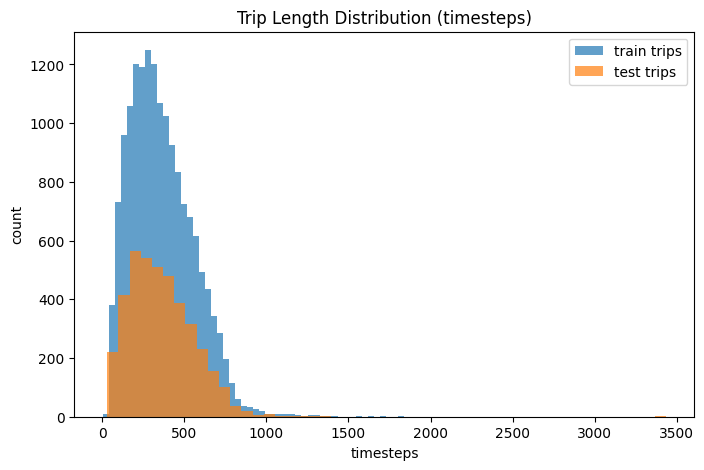

In [9]:
# ---- time-series sanity: trip length distribution ----
train_lens = np.array([len(x) for x in X_train_seqs], dtype=int)
test_lens  = np.array([len(x) for x in X_test_seqs], dtype=int)

print("\ntrip length stats (train):",
      "min", train_lens.min(), "p50", int(np.median(train_lens)), "p95", int(np.quantile(train_lens, 0.95)), "max", train_lens.max())
print("trip length stats (test):",
      "min", test_lens.min(), "p50", int(np.median(test_lens)), "p95", int(np.quantile(test_lens, 0.95)), "max", test_lens.max())

plt.figure(figsize=(8,5))
plt.hist(train_lens, bins=50, alpha=0.7, label="train trips")
plt.hist(test_lens, bins=50, alpha=0.7, label="test trips")
plt.title("Trip Length Distribution (timesteps)")
plt.xlabel("timesteps")
plt.ylabel("count")
plt.legend()
plt.show()

#

# **Create a validation split (trip-level) for model selection**

Unlike many deep learning pipelines, HMM performance depends heavily on:
- number of hidden states (`n_components`)
- convergence settings (`n_iter`, `tol`)
- decision threshold for likelihood comparison

To avoid tuning on the test set (data leakage), we split the official training trips into:
- Train (for fitting models)
- Validation (for selecting hyperparameters and threshold)

The test set is used only once at the end for final reporting.

---

In [10]:
idx = np.arange(len(X_train_seqs))
train_idx, val_idx = train_test_split(
    idx,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

X_tr = [X_train_seqs[i] for i in train_idx]
y_tr = y_train[train_idx]

X_val = [X_train_seqs[i] for i in val_idx]
y_val = y_train[val_idx]

print("train trips:", len(X_tr), "\nval trips:", len(X_val), "\ntest trips:", len(X_test_seqs))
print("y_train dist:", np.bincount(y_tr))
print("y_val dist:", np.bincount(y_val))

train trips: 12781 
val trips: 3196 
test trips: 3995
y_train dist: [9596 3185]
y_val dist: [2399  797]


#

# **Feature scaling (fit on train only)**

HMM emissions assume continuous features with stable scale.  
We standardize sensor channels using a `StandardScaler` fitted only on the training set to prevent leakage.

The scaler is then applied to validation and test sequences using the same parameters.

---

In [11]:
scaler = StandardScaler()
scaler.fit(np.vstack(X_tr))  # fit only on train

def scale_seqs(seqs):
    return [scaler.transform(x) for x in seqs]

X_tr_s  = scale_seqs(X_tr)
X_val_s = scale_seqs(X_val)
X_te_s  = scale_seqs(X_test_seqs)
print("Scaled example trip (first 3 rows):")
print(X_tr_s[0][:3])

Scaled example trip (first 3 rows):
[[-7.79733140e-01 -1.00318897e-01  6.01923571e-01  5.48462674e-01
   9.48328570e-02 -6.96842986e-02 -6.70542003e-04  2.54479798e-01
  -2.91104817e-01]
 [-8.23096798e-01 -1.00318897e-01  6.13781962e-01  5.41720927e-01
  -2.13757780e-02 -1.57424838e-03  2.75154999e-03  3.10654256e-01
  -3.70482059e-01]
 [-9.89117662e-01 -1.17583968e-01  6.61217509e-01  4.36087446e-01
   7.37920568e-01 -1.39458003e-02  1.91854359e-02  3.10654256e-01
  -4.24140030e-01]]


#

# **Experiment Plan (Baseline → Tune → Improve)**

This notebook follows an iterative experiment cycle, aligned to CA2 grading (process > raw accuracy). 

We will run **3 stages**, and each stage will be tracked in MLflow:

##### Stage A — Baseline
Goal: establish a simple starting point (a “control”).
1. Train two Gaussian HMMs:
   - HMM_safe trained using trips labelled 0
   - HMM_danger trained using trips labelled 1
2. Predict using log-likelihood difference:
   score = logP(X|danger) − logP(X|safe)
   predict 1 if score > 0
3. Evaluate on validation set (no tuning yet)
4. Log metrics + plots + artifacts in MLflow

##### Stage B — Hyperparameter Tuning
Goal: improve the baseline systematically.
1. Tune HMM hyperparameters (e.g., n_states, tol, n_iter, min_covar)
2. For each config, also tune decision threshold on validation
3. Log **every run** to MLflow (so improvement is traceable)

##### Stage C — Model Improvement (research-inspired)
Goal: apply a justified change to the modelling pipeline, not random changes.
Research shows HMM driving analysis performance depends heavily on preprocessing/derived signals (e.g., filtering noise, jerk-like dynamics, slope features). :contentReference[oaicite:2]{index=2} :contentReference[oaicite:3]{index=3}
We will test one improvement (e.g., filtering short trips, removing noisy GPS fields, adding delta/jerk features), then re-run training + evaluation.

##### Final Step — Test Set (once)
After choosing the best pipeline using validation, evaluate **once** on test for final reporting.

---

In [12]:
# -----------------------------
# helpers for hmm training + evaluation + plots
# -----------------------------
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve
)

def concat_seqs_by_label(seqs, labels, target_label):
    Xs, lens = [], []
    for X, y in zip(seqs, labels):
        if int(y) == int(target_label):
            Xs.append(X)
            lens.append(len(X))
    if len(Xs) == 0:
        raise ValueError(f"no sequences found for label {target_label}")
    return np.vstack(Xs), lens

def ll_diff_scores(hmm_safe, hmm_danger, seqs):
    # score = logP(X|danger) - logP(X|safe)
    return np.array([hmm_danger.score(X) - hmm_safe.score(X) for X in seqs], dtype=float)

def predict_from_scores(scores, threshold=0.0):
    return (np.asarray(scores) > float(threshold)).astype(int)

def best_threshold_by_f1(y_true, scores, n=60):
    y_true = np.asarray(y_true, dtype=int)
    scores = np.asarray(scores, dtype=float)

    qs = np.linspace(0.02, 0.98, n)
    cand = np.unique(np.quantile(scores, qs))

    best_f1, best_t = -1.0, 0.0
    for t in cand:
        pred = predict_from_scores(scores, threshold=float(t))
        f1 = f1_score(y_true, pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, float(t)
    return float(best_f1), float(best_t)

def evaluate_scores(y_true, scores, threshold):
    """
    HMM produces continuous scores (ll_diff). This evaluates classification metrics
    at a chosen threshold and also computes ranking metrics (ROC-AUC, PR-AUC).
    """
    y_true = np.asarray(y_true, dtype=int)
    scores = np.asarray(scores, dtype=float)
    y_pred = predict_from_scores(scores, threshold=threshold)

    metrics = {
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "roc_auc": float(roc_auc_score(y_true, scores)) if len(np.unique(y_true)) == 2 else float("nan"),
        "pr_auc": float(average_precision_score(y_true, scores)) if len(np.unique(y_true)) == 2 else float("nan"),
    }
    cm = confusion_matrix(y_true, y_pred)
    rep = classification_report(y_true, y_pred, digits=4, zero_division=0)
    return metrics, cm, rep, y_pred

def plot_confusion_matrix(cm, title):
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm)
    ax.set_title(title)
    ax.set_xlabel("pred")
    ax.set_ylabel("true")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["safe(0)","danger(1)"])
    ax.set_yticklabels(["safe(0)","danger(1)"])
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    fig.tight_layout()
    return fig

def plot_score_hist(scores, y_true, title):
    y_true = np.asarray(y_true, dtype=int)
    scores = np.asarray(scores, dtype=float)

    fig, ax = plt.subplots(figsize=(8,5))
    ax.hist(scores[y_true == 0], bins=40, alpha=0.6, label="true=0 (safe)")
    ax.hist(scores[y_true == 1], bins=40, alpha=0.6, label="true=1 (danger)")
    ax.set_title(title)
    ax.set_xlabel("ll_diff = ll(danger) - ll(safe)")
    ax.set_ylabel("count")
    ax.legend()
    fig.tight_layout()
    return fig

def plot_f1_vs_threshold(y_true, scores, title, n=80):
    y_true = np.asarray(y_true, dtype=int)
    scores = np.asarray(scores, dtype=float)

    qs = np.linspace(0.02, 0.98, n)
    cand = np.unique(np.quantile(scores, qs))
    f1s = []
    for t in cand:
        pred = predict_from_scores(scores, threshold=float(t))
        f1s.append(f1_score(y_true, pred, zero_division=0))

    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(cand, f1s)
    ax.set_title(title)
    ax.set_xlabel("threshold")
    ax.set_ylabel("f1")
    fig.tight_layout()
    return fig

def plot_roc_curve(y_true, scores, title):
    y_true = np.asarray(y_true, dtype=int)
    scores = np.asarray(scores, dtype=float)
    fpr, tpr, _ = roc_curve(y_true, scores)
    auc = roc_auc_score(y_true, scores)

    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(fpr, tpr, label=f"AUC={auc:.4f}")
    ax.plot([0,1],[0,1], linestyle="--", label="random")
    ax.set_title(title)
    ax.set_xlabel("false positive rate")
    ax.set_ylabel("true positive rate")
    ax.legend()
    fig.tight_layout()
    return fig

def plot_pr_curve(y_true, scores, title):
    y_true = np.asarray(y_true, dtype=int)
    scores = np.asarray(scores, dtype=float)
    p, r, _ = precision_recall_curve(y_true, scores)
    ap = average_precision_score(y_true, scores)

    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(r, p, label=f"AP={ap:.4f}")
    ax.set_title(title)
    ax.set_xlabel("recall")
    ax.set_ylabel("precision")
    ax.legend()
    fig.tight_layout()
    return fig

print("helpers loaded ok (extended)")

helpers loaded ok (extended)


#

# **Stage A — Baseline Training (no tuning)**

We train a **class-conditional** HMM setup:
- one HMM learns “normal/safe” dynamics
- one HMM learns “dangerous” dynamics

This is baseline because:
- we use one reasonable default configuration
- we do not search multiple hyperparameters yet
- we use threshold = 0 (simple likelihood comparison)

This gives us a starting point to compare against later improvements.

---

In [13]:
# -----------------------------
# stage a1: baseline training
# -----------------------------
baseline_params = {
    "n_states": 4,
    "covariance_type": "diag",
    "n_iter": 120,
    "tol": 1e-3,
    "min_covar": 1e-3,
    "seed": 42,
}

# train using TRAIN split only
X0_tr, lens0_tr = concat_seqs_by_label(X_tr_s, y_tr, 0)
X1_tr, lens1_tr = concat_seqs_by_label(X_tr_s, y_tr, 1)

hmm_safe_base = GaussianHMM(
    n_components=baseline_params["n_states"],
    covariance_type=baseline_params["covariance_type"],
    n_iter=baseline_params["n_iter"],
    tol=baseline_params["tol"],
    min_covar=baseline_params["min_covar"],
    random_state=baseline_params["seed"],
)
hmm_danger_base = GaussianHMM(
    n_components=baseline_params["n_states"],
    covariance_type=baseline_params["covariance_type"],
    n_iter=baseline_params["n_iter"],
    tol=baseline_params["tol"],
    min_covar=baseline_params["min_covar"],
    random_state=baseline_params["seed"],
)

hmm_safe_base.fit(X0_tr, lens0_tr)
hmm_danger_base.fit(X1_tr, lens1_tr)

print("baseline trained:", baseline_params)

c:\Users\ezinn\anaconda3\envs\gpu_env\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Model is not converging.  Current: -10614083.61931723 is not greater than -10614083.619278591. Delta is -3.863871097564697e-05


baseline trained: {'n_states': 4, 'covariance_type': 'diag', 'n_iter': 120, 'tol': 0.001, 'min_covar': 0.001, 'seed': 42}


#

# **Stage A — Baseline Evaluation (validation)**

We evaluate on the **validation set** (not test) so we can still tune later without leaking information.

Prediction rule (baseline):
- score = logP(X|danger) − logP(X|safe)
- predict dangerous if score > 0

We log metrics + plots to MLflow so results remain reproducible and comparable.

---

stageA threshold (picked on val): -1571.1676616508623
train metrics: {'f1': 0.39026250556155856, 'precision': 0.24466050366592285, 'recall': 0.9638932496075353, 'roc_auc': 0.47775518711027554, 'pr_auc': 0.2667381537920062}
val metrics: {'f1': 0.38533978111478745, 'precision': 0.241698595146871, 'recall': 0.9498117942283564, 'roc_auc': 0.45527857435370134, 'pr_auc': 0.2594004455617568}

val report:
               precision    recall  f1-score   support

           0     0.3750    0.0100    0.0195      2399
           1     0.2417    0.9498    0.3853       797

    accuracy                         0.2444      3196
   macro avg     0.3083    0.4799    0.2024      3196
weighted avg     0.3418    0.2444    0.1107      3196



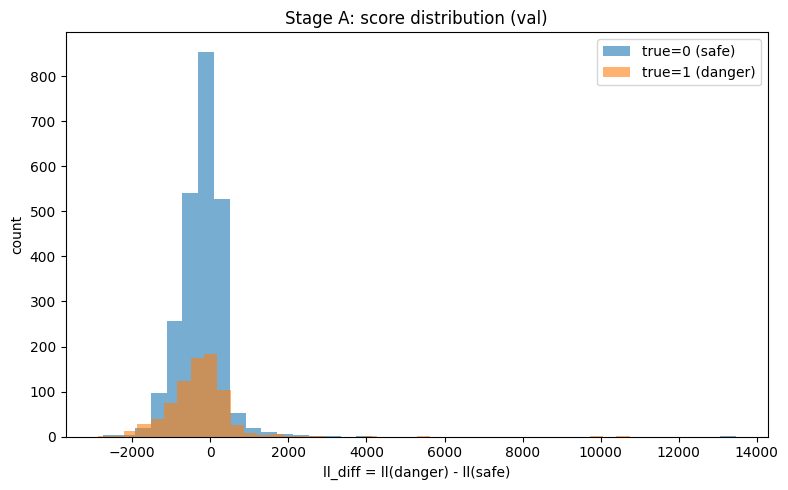

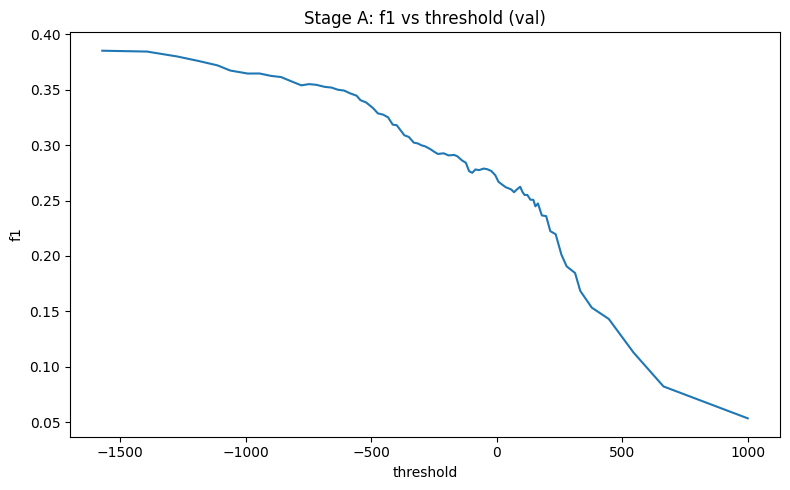

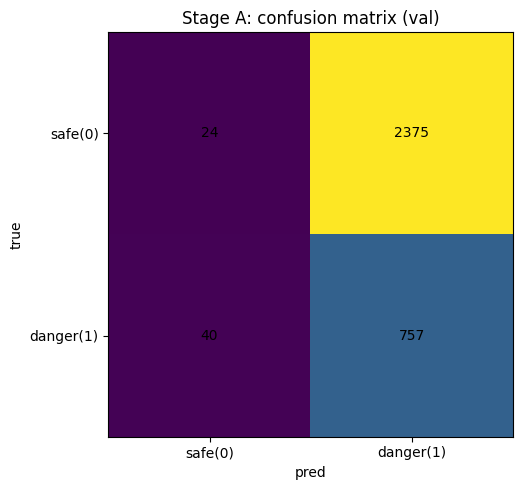

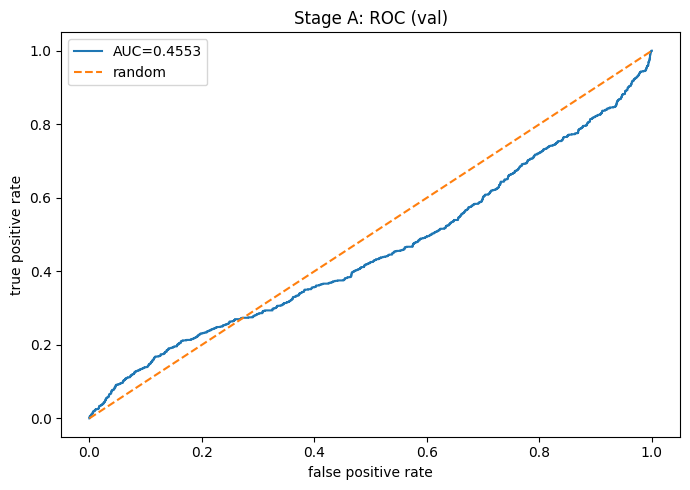

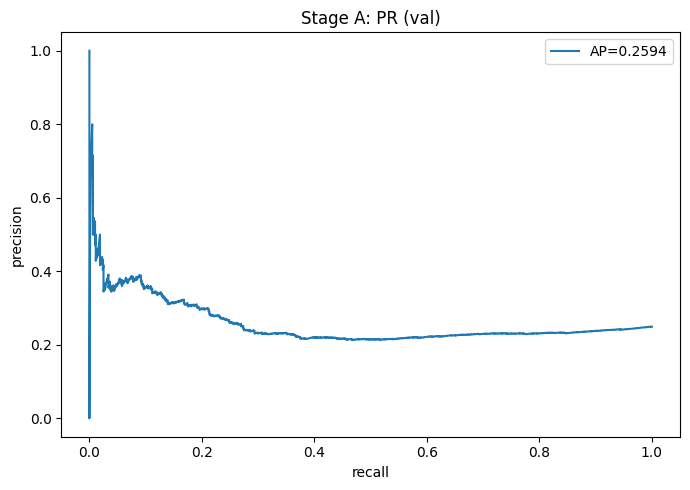

2026/01/31 17:10:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run stageA_baseline at: http://127.0.0.1:5000/#/experiments/17/runs/5bf7ff7d9b3d441dafa1991aa3ccf7fb.
2026/01/31 17:10:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17.


In [14]:
with mlflow.start_run(run_name="stageA_baseline"):
    # params
    mlflow.log_params(baseline_params)
    mlflow.log_param("stage", "A_baseline")
    mlflow.log_param("dataset", os.path.basename(DATA_PATH))
    mlflow.log_param("split_file", os.path.basename(SPLIT_PATH))
    mlflow.log_param("obs_cols", ",".join(obs_cols))

    # ---- score train + val ----
    tr_scores = ll_diff_scores(hmm_safe_base, hmm_danger_base, X_tr_s)
    val_scores = ll_diff_scores(hmm_safe_base, hmm_danger_base, X_val_s)

    # choose threshold using validation (proper workflow)
    best_f1, best_t = best_threshold_by_f1(y_val, val_scores)
    mlflow.log_param("val_threshold", float(best_t))

    # evaluate train at the chosen val threshold (overfit check)
    tr_metrics, tr_cm, tr_rep, _ = evaluate_scores(y_tr, tr_scores, best_t)
    val_metrics, val_cm, val_rep, _ = evaluate_scores(y_val, val_scores, best_t)

    # overfit indicator similar to GB notebook
    overfit_gap = tr_metrics["f1"] - val_metrics["f1"]
    mlflow.log_metric("overfit_gap_f1", float(overfit_gap))

    # log metrics
    for k, v in tr_metrics.items():
        mlflow.log_metric(f"train_{k}", float(v))
    for k, v in val_metrics.items():
        mlflow.log_metric(f"val_{k}", float(v))

    print("stageA threshold (picked on val):", best_t)
    print("train metrics:", tr_metrics)
    print("val metrics:", val_metrics)
    print("\nval report:\n", val_rep)

    # ---- figures (show + log to mlflow) ----
    fig_hist = plot_score_hist(val_scores, y_val, "Stage A: score distribution (val)")
    mlflow.log_figure(fig_hist, "stageA_val_score_hist.png")
    plt.show()

    fig_f1 = plot_f1_vs_threshold(y_val, val_scores, "Stage A: f1 vs threshold (val)")
    mlflow.log_figure(fig_f1, "stageA_val_f1_vs_threshold.png")
    plt.show()

    fig_cm = plot_confusion_matrix(val_cm, "Stage A: confusion matrix (val)")
    mlflow.log_figure(fig_cm, "stageA_val_confusion.png")
    plt.show()

    # ranking curves (new)
    fig_roc = plot_roc_curve(y_val, val_scores, "Stage A: ROC (val)")
    mlflow.log_figure(fig_roc, "stageA_val_roc.png")
    plt.show()

    fig_pr = plot_pr_curve(y_val, val_scores, "Stage A: PR (val)")
    mlflow.log_figure(fig_pr, "stageA_val_pr.png")
    plt.show()

    # save + log reports
    rep_path = os.path.join(ART_DIR, "stageA_val_report.txt")
    with open(rep_path, "w", encoding="utf-8") as f:
        f.write(val_rep)
    mlflow.log_artifact(rep_path)

#

# **Stage B — Hyperparameter Tuning (tracked in MLflow)**

We now tune the baseline systematically.
For each hyperparameter setting:
1. train the two HMMs on TRAIN
2. score the validation set
3. choose the best decision threshold on validation (maximize F1)
4. log parameters + metrics into MLflow

---

In [15]:
# -----------------------------
# stage b: light hyperparameter tuning (logs every run to mlflow)
# -----------------------------

# collect every trial result into a summary table (like ablation study)
tuning_rows = []

# --- tuning speed knobs ---
TUNING_MAX_TRIPS_PER_CLASS = 120     # cap training trips used during tuning per class
TUNING_N_STATES = [3, 4, 6]          # small but meaningful search
TUNING_N_ITER = [80, 150]            # fewer em iterations
TUNING_TOL = [1e-2]                  # one reasonable tol
TUNING_MIN_COVAR = [1e-3]            # stable default

grid = {
    "n_states": TUNING_N_STATES,
    "n_iter": TUNING_N_ITER,
    "tol": TUNING_TOL,
    "min_covar": TUNING_MIN_COVAR,
}

best = {"val_f1": -1.0, "params": None, "threshold": 0.0}

# prebuild (X, lengths) once so we do not redo huge vstack work every loop
# we also subsample trips to keep training time sane
def _subsample_by_label(seqs, labels, target_label, max_trips, seed=42):
    idx = [i for i,y in enumerate(labels) if int(y) == int(target_label)]
    if len(idx) == 0:
        raise ValueError(f"no sequences found for label {target_label}")
    rng = np.random.default_rng(seed)
    if len(idx) > max_trips:
        idx = rng.choice(idx, size=max_trips, replace=False).tolist()
    Xs = [seqs[i] for i in idx]
    ys = [labels[i] for i in idx]
    return Xs, np.array(ys, dtype=int)

X_tr0_s, y_tr0 = _subsample_by_label(X_tr_s, y_tr, 0, TUNING_MAX_TRIPS_PER_CLASS, seed=42)
X_tr1_s, y_tr1 = _subsample_by_label(X_tr_s, y_tr, 1, TUNING_MAX_TRIPS_PER_CLASS, seed=43)

X0_tune, lens0_tune = concat_seqs_by_label(X_tr0_s, y_tr0, 0)
X1_tune, lens1_tune = concat_seqs_by_label(X_tr1_s, y_tr1, 1)

with mlflow.start_run(run_name="stageB_tuning_parent") as parent:
    # parent run stores the tuning config
    mlflow.log_param("stage", "stageB_tuning_parent")
    mlflow.log_param("dataset", os.path.basename(DATA_PATH))
    mlflow.log_param("obs_cols", ",".join(obs_cols))
    mlflow.log_param("tuning_max_trips_per_class", int(TUNING_MAX_TRIPS_PER_CLASS))

    run_id = 0
    for n_states in grid["n_states"]:
        for n_iter in grid["n_iter"]:
            for tol in grid["tol"]:
                for min_covar in grid["min_covar"]:
                    run_id += 1
                    params = dict(
                        n_states=int(n_states),
                        covariance_type="diag",
                        n_iter=int(n_iter),
                        tol=float(tol),
                        min_covar=float(min_covar),
                        seed=42,
                    )

                    # each child run is one candidate model config
                    with mlflow.start_run(run_name=f"stageB_tuned_{run_id:03d}", nested=True):
                        for k, v in params.items():
                            mlflow.log_param(k, v)
                        mlflow.log_param("stage", "stageB_tuned")

                        # train on the subsampled train set
                        hmm_safe = GaussianHMM(
                            n_components=params["n_states"],
                            covariance_type=params["covariance_type"],
                            n_iter=params["n_iter"],
                            tol=params["tol"],
                            min_covar=params["min_covar"],
                            random_state=params["seed"],
                        )
                        hmm_danger = GaussianHMM(
                            n_components=params["n_states"],
                            covariance_type=params["covariance_type"],
                            n_iter=params["n_iter"],
                            tol=params["tol"],
                            min_covar=params["min_covar"],
                            random_state=params["seed"],
                        )

                        hmm_safe.fit(X0_tune, lens0_tune)
                        hmm_danger.fit(X1_tune, lens1_tune)

                        # score validation (full val set)
                        val_scores = ll_diff_scores(hmm_safe, hmm_danger, X_val_s)

                        # tune threshold on validation
                        _, best_t = best_threshold_by_f1(y_val, val_scores)
                        y_val_pred = predict_from_scores(val_scores, threshold=best_t)

                        f1 = f1_score(y_val, y_val_pred, zero_division=0)
                        prec = precision_score(y_val, y_val_pred, zero_division=0)
                        rec = recall_score(y_val, y_val_pred, zero_division=0)

                        mlflow.log_metric("val_f1", float(f1))
                        mlflow.log_metric("val_precision", float(prec))
                        mlflow.log_metric("val_recall", float(rec))
                        mlflow.log_param("threshold", float(best_t))

                        # store trial summary for later comparison (leaderboard)
                        tuning_rows.append({
                            **params,
                            "threshold": float(best_t),
                            "val_f1": float(f1),
                            "val_precision": float(prec),
                            "val_recall": float(rec),
                        })

                        if float(f1) > best["val_f1"]:
                            best = {"val_f1": float(f1), "params": params, "threshold": float(best_t)}

print("best tuning result:", best)


2026/01/31 17:10:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run stageB_tuned_001 at: http://127.0.0.1:5000/#/experiments/17/runs/e3b68cec9d634e7991d325d2ccc13025.
2026/01/31 17:10:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17.
2026/01/31 17:10:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run stageB_tuned_002 at: http://127.0.0.1:5000/#/experiments/17/runs/12c73f0934d7402db7a42ce4da54b7f5.
2026/01/31 17:10:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17.
2026/01/31 17:10:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run stageB_tuned_003 at: http://127.0.0.1:5000/#/experiments/17/runs/1ac9439be0ed49479b00dd68bf7c0558.
2026/01/31 17:10:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17.
2026/01/31 17:10:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run stag

best tuning result: {'val_f1': 0.40032349373230897, 'params': {'n_states': 6, 'covariance_type': 'diag', 'n_iter': 80, 'tol': 0.01, 'min_covar': 0.001, 'seed': 42}, 'threshold': 230.4006656404547}


#

# **Stage B — Re-evaluate the best tuned configuration (validation)**

The tuning stage produces many runs.  
Here we take the best configuration and run a clean evaluation again (with plots) so results are easy to interpret without digging through MLflow.

---


best_params: {'n_states': 6, 'covariance_type': 'diag', 'n_iter': 80, 'tol': 0.01, 'min_covar': 0.001, 'seed': 42}
best_threshold: 230.4006656404547


Model is not converging.  Current: -7330576.2163252905 is not greater than -7330576.1342241755. Delta is -0.08210111502557993


              precision    recall  f1-score   support

           0     0.7594    0.9604    0.8482      2399
           1     0.4136    0.0841    0.1397       797

    accuracy                         0.7419      3196
   macro avg     0.5865    0.5222    0.4939      3196
weighted avg     0.6732    0.7419    0.6715      3196



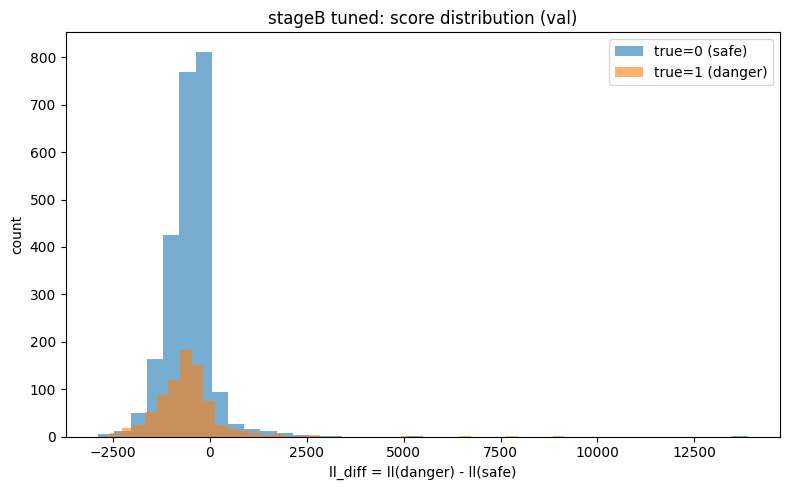

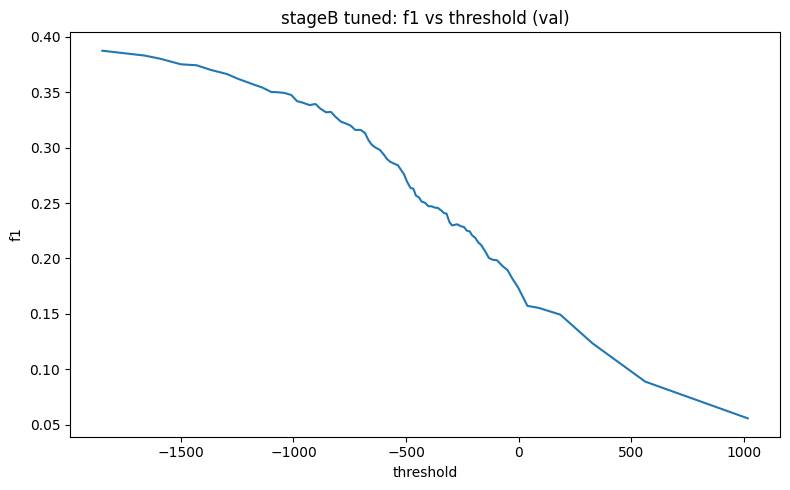

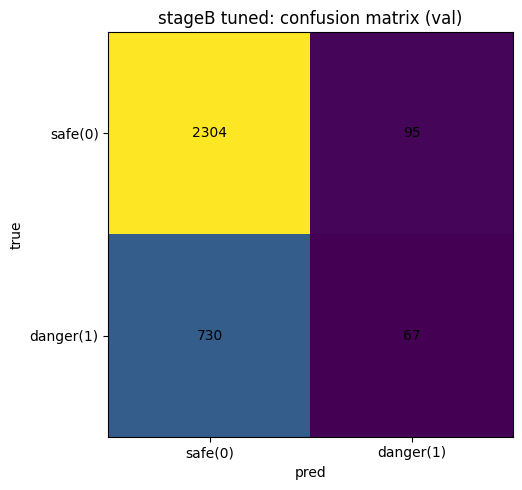

In [16]:
# -----------------------------
# stage b: retrain best config + evaluate on validation
# -----------------------------

# extract best tuning result
best_params = best["params"]
best_threshold = best["threshold"]

assert best_params is not None, "best_params is None. stageB tuning did not find a config."
print("best_params:", best_params)
print("best_threshold:", best_threshold)

# ---- train best model again on FULL training set (not subsampled) ----
hmm_safe_best = GaussianHMM(
    n_components=best_params["n_states"],
    covariance_type=best_params.get("covariance_type", "diag"),
    n_iter=best_params["n_iter"],
    tol=best_params["tol"],
    min_covar=best_params["min_covar"],
    random_state=best_params["seed"],
)
hmm_danger_best = GaussianHMM(
    n_components=best_params["n_states"],
    covariance_type=best_params.get("covariance_type", "diag"),
    n_iter=best_params["n_iter"],
    tol=best_params["tol"],
    min_covar=best_params["min_covar"],
    random_state=best_params["seed"],
)

X0_tr, lens0_tr = concat_seqs_by_label(X_tr_s, y_tr, 0)
X1_tr, lens1_tr = concat_seqs_by_label(X_tr_s, y_tr, 1)

hmm_safe_best.fit(X0_tr, lens0_tr)
hmm_danger_best.fit(X1_tr, lens1_tr)

# ---- evaluate on validation ----
val_scores_best = ll_diff_scores(hmm_safe_best, hmm_danger_best, X_val_s)
y_val_pred_best = predict_from_scores(val_scores_best, threshold=best_threshold)

cm_best = confusion_matrix(y_val, y_val_pred_best)
rep_best = classification_report(y_val, y_val_pred_best, digits=4, zero_division=0)

print(rep_best)

# ---- plots (fig-returning versions; no plot_confusion) ----
fig_hist = plot_score_hist(val_scores_best, y_val, "stageB tuned: score distribution (val)")
plt.show()

fig_f1 = plot_f1_vs_threshold(y_val, val_scores_best, "stageB tuned: f1 vs threshold (val)")
plt.show()

fig_cm = plot_confusion_matrix(cm_best, "stageB tuned: confusion matrix (val)")
plt.show()

#

# **Stage C — Model Improvement (feature representation + data quality)**

Stage B improved performance by tuning HMM hyperparameters.  
However, HMMs are highly sensitive to **how the time-series is represented**.

In this stage, we attempt a practical improvement that is easy to justify:

#### Why this improvement makes sense
1. **Remove noisy signals (optional)**  
   Certain GPS-related fields (e.g., `accuracy`, `bearing`) can be very noisy and may reduce the model’s ability to separate safe vs dangerous patterns.

2. **Filter short trips**  
   HMM training (EM algorithm) needs enough timesteps to estimate transitions/emissions. Very short sequences often add noise and cause unstable fits.

3. **Add delta (change) features**
   Dangerous driving often shows up as rapid changes (hard braking, sudden turns).  
   We add first differences (Δ) of each sensor channel as additional features.

#### What we will do
- Apply the improvement pipeline to the already-scaled sequences:
  - (optional) drop noisy columns
  - filter short trips
  - add delta features
- Retrain using the **best hyperparameters from Stage B**
- Tune a new threshold on validation (because representation changed)
- Evaluate and log results (metrics + plots + artifacts) into MLflow as a new run

This produces a comparable “Stage C” result that we can directly compare against Stage A (baseline) and Stage B (tuned).

---

In [17]:
# -----------------------------
# stage c: config + helper functions
# -----------------------------

# fail early if notebook state is broken
assert "best_params" in globals() and best_params is not None, "best_params missing. run stage b tuning first."
assert "X_tr_s" in globals() and "X_val_s" in globals(), "missing X_tr_s / X_val_s. run data prep + scaling cells first."
assert "y_tr" in globals() and "y_val" in globals(), "missing y_tr / y_val. run split cells first."
assert "obs_cols" in globals() and len(obs_cols) > 0, "obs_cols missing. run feature selection cell first."

print("stageC using best_params:", best_params)

# hold the stage c run id so later cells can resume the same run (prevents random 'defiant-fish' runs)
STAGEC_RUN_ID = None

# improvement settings
STAGEC_MIN_LEN = 20          # drop very short trips (length in timesteps)
STAGEC_USE_DELTAS = True     # add first-difference features
STAGEC_DROP_NOISY_GPS = True # drop accuracy/bearing if present in obs_cols

# columns to drop (only if present)
drop_cols = set()
if STAGEC_DROP_NOISY_GPS:
    drop_cols |= {"accuracy", "bearing"}

# map columns -> indices for slicing
col_to_idx = {c: i for i, c in enumerate(obs_cols)}
drop_cols_present = [c for c in drop_cols if c in col_to_idx]

# indices we keep (stable ordering)
keep_idx = sorted([i for c, i in col_to_idx.items() if c not in drop_cols_present])

print("drop_cols_present:", drop_cols_present)
print("kept feature count:", len(keep_idx), "/", len(obs_cols))


def apply_keep_idx(seqs, keep_idx):
    # keep only selected feature columns for each sequence
    return [X[:, keep_idx] for X in seqs]


def filter_min_len(seqs, labels, min_len):
    # drop sequences shorter than min_len while keeping labels aligned
    Xo, yo = [], []
    for X, y in zip(seqs, labels):
        if len(X) >= min_len:
            Xo.append(X)
            yo.append(int(y))
    return Xo, np.array(yo, dtype=int)


def add_delta_features(seqs):
    """
    For each sequence X (T, D):
    - dX = diff(X) => (T-1, D)
    - new sequence = concat([X[1:], dX]) => (T-1, 2D)
    This emphasizes changes (hard braking, sharp turns, etc.)
    """
    out = []
    for X in seqs:
        if len(X) < 2:
            continue
        dX = np.diff(X, axis=0)
        X2 = X[1:, :]
        out.append(np.hstack([X2, dX]))
    return out

print("stageC helpers loaded")

stageC using best_params: {'n_states': 6, 'covariance_type': 'diag', 'n_iter': 80, 'tol': 0.01, 'min_covar': 0.001, 'seed': 42}
drop_cols_present: ['bearing', 'accuracy']
kept feature count: 7 / 9
stageC helpers loaded


In [18]:
# -----------------------------
# stage c: apply representation improvements
# -----------------------------

# 1) drop selected columns
X_tr_imp = apply_keep_idx(X_tr_s, keep_idx)
X_val_imp = apply_keep_idx(X_val_s, keep_idx)

# 2) filter short trips before deltas (so STAGEC_MIN_LEN stays meaningful)
X_tr_imp, y_tr_imp = filter_min_len(X_tr_imp, y_tr, STAGEC_MIN_LEN)
X_val_imp, y_val_imp = filter_min_len(X_val_imp, y_val, STAGEC_MIN_LEN)

assert "y_val_imp" in globals() and y_val_imp is not None, "y_val_imp missing. run this cell fully before stageC training."

# 3) add delta features (each sequence loses 1 timestep)
if STAGEC_USE_DELTAS:
    X_tr_imp = add_delta_features(X_tr_imp)
    X_val_imp = add_delta_features(X_val_imp)

print("stageC train trips:", len(X_tr_imp), "val trips:", len(X_val_imp))
print("stageC y_train dist:", np.bincount(y_tr_imp) if len(y_tr_imp) > 0 else None)
print("stageC y_val dist:", np.bincount(y_val_imp) if len(y_val_imp) > 0 else None)

# quick sanity: if deltas are enabled, we need at least 2 timesteps originally (now >=1)
assert len(X_tr_imp) > 0 and len(X_val_imp) > 0, "stageC produced empty train/val after filtering. lower STAGEC_MIN_LEN."

stageC train trips: 12776 val trips: 3196
stageC y_train dist: [9592 3184]
stageC y_val dist: [2399  797]


Model is not converging.  Current: 1397076.7157091764 is not greater than 1397085.8682252786. Delta is -9.152516102185473


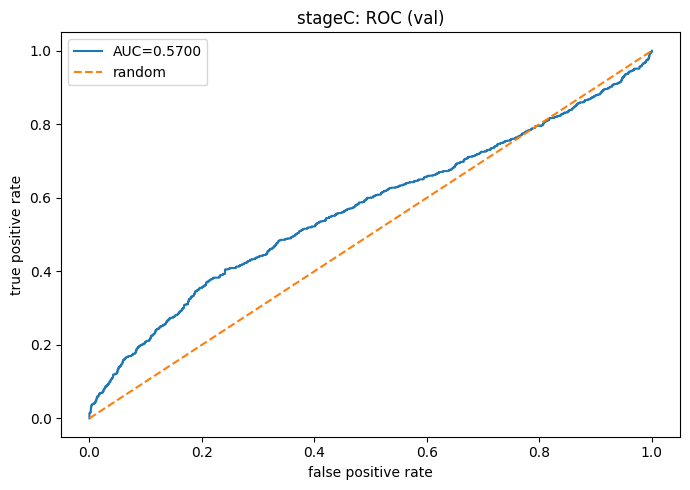

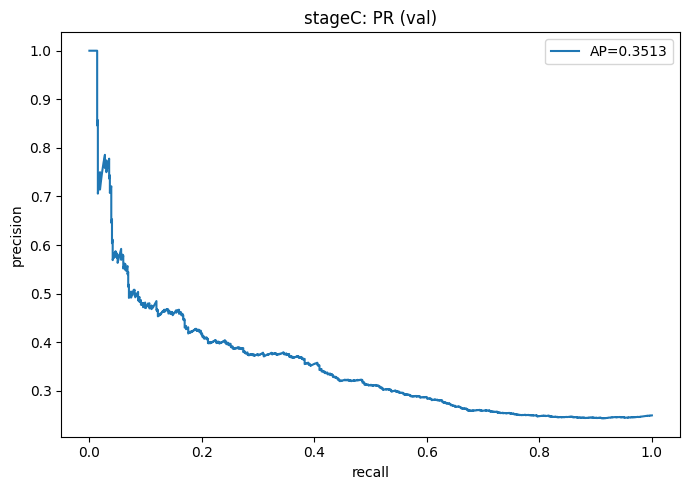

stageC run id: d0bd70e095b84dbda19c875b81b50111
stageC tuned threshold: -1201.5028085917631
stageC val_f1: 0.3914482056502927
              precision    recall  f1-score   support

           0     0.5625    0.0150    0.0292      2399
           1     0.2455    0.9649    0.3914       797

    accuracy                         0.2519      3196
   macro avg     0.4040    0.4899    0.2103      3196
weighted avg     0.4835    0.2519    0.1196      3196



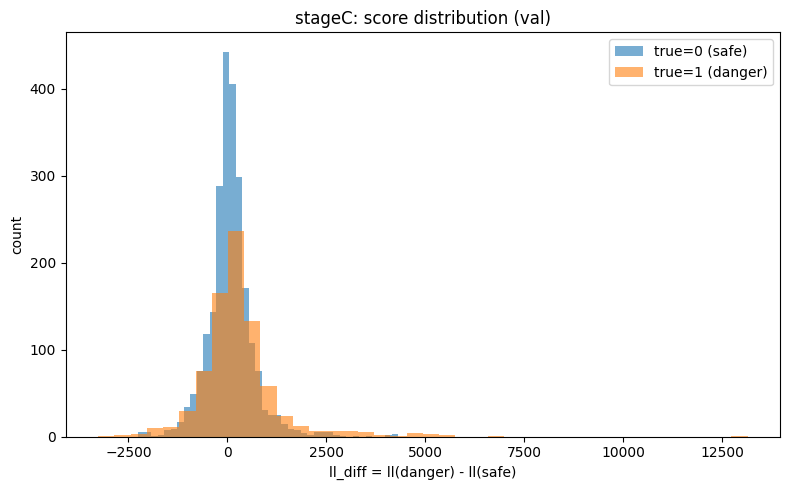

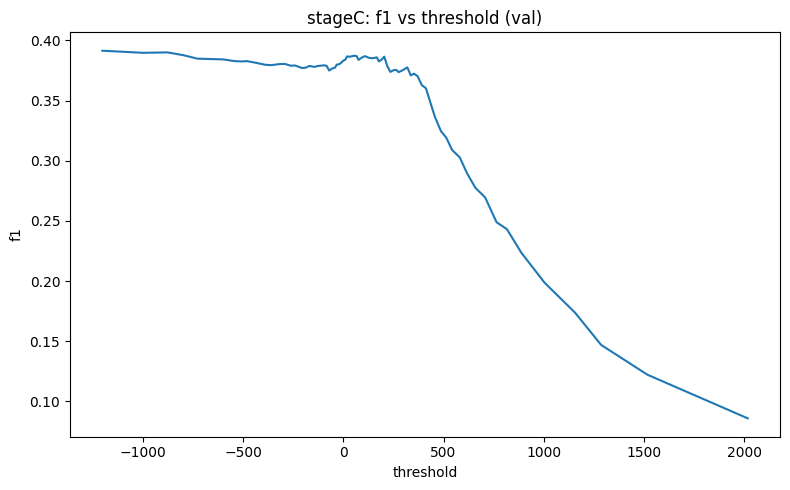

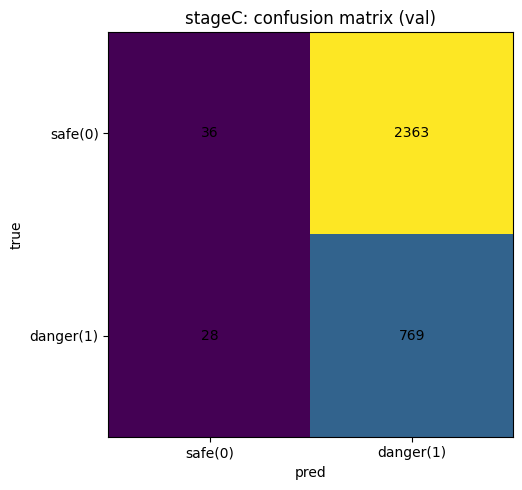

2026/01/31 17:33:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run stageC_improved at: http://127.0.0.1:5000/#/experiments/17/runs/d0bd70e095b84dbda19c875b81b50111.
2026/01/31 17:33:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17.


In [19]:
# -----------------------------
# stage c: train + evaluate (validation) with mlflow logging
# -----------------------------

RUN_NAME = "stageC_improved"   # consistent naming across runs
STAGEC_RUN_ID = None          # used by later artifact cells (resume run_id to avoid random runs)

with mlflow.start_run(run_name=RUN_NAME) as run:
    # stash the run id so later cells can resume this exact run
    STAGEC_RUN_ID = run.info.run_id

    # ---- log stage identity + improvement settings ----
    mlflow.log_param("stage", RUN_NAME)
    mlflow.log_param("stageC_min_len", int(STAGEC_MIN_LEN))
    mlflow.log_param("stageC_use_deltas", bool(STAGEC_USE_DELTAS))
    mlflow.log_param("stageC_drop_noisy_gps", bool(STAGEC_DROP_NOISY_GPS))
    mlflow.log_param("stageC_dropped_cols", ",".join(drop_cols_present) if drop_cols_present else "")
    mlflow.log_param("stageC_kept_features", int(len(keep_idx)))

    # log best hyperparams used (from stage b)
    for k, v in best_params.items():
        mlflow.log_param(f"best_{k}", v)

    # ---- train two class-conditional hmms ----
    # model 0 = safe trips, model 1 = dangerous trips
    X0_tr, lens0_tr = concat_seqs_by_label(X_tr_imp, y_tr_imp, 0)
    X1_tr, lens1_tr = concat_seqs_by_label(X_tr_imp, y_tr_imp, 1)

    hmm_safe_c = GaussianHMM(
        n_components=best_params["n_states"],
        covariance_type=best_params["covariance_type"],
        n_iter=best_params["n_iter"],
        tol=best_params["tol"],
        min_covar=best_params["min_covar"],
        random_state=best_params["seed"],
    )
    hmm_danger_c = GaussianHMM(
        n_components=best_params["n_states"],
        covariance_type=best_params["covariance_type"],
        n_iter=best_params["n_iter"],
        tol=best_params["tol"],
        min_covar=best_params["min_covar"],
        random_state=best_params["seed"],
    )

    hmm_safe_c.fit(X0_tr, lens0_tr)
    hmm_danger_c.fit(X1_tr, lens1_tr)

    # ---- score validation (continuous scores) ----
    # score = logP(X|danger) - logP(X|safe)
    val_scores_c = ll_diff_scores(hmm_safe_c, hmm_danger_c, X_val_imp)

    # ---- ranking metrics (threshold-free; good for report) ----
    mlflow.log_metric("val_roc_auc", float(roc_auc_score(y_val_imp, val_scores_c)))
    mlflow.log_metric("val_pr_auc", float(average_precision_score(y_val_imp, val_scores_c)))

    fig_roc = plot_roc_curve(y_val_imp, val_scores_c, "stageC: ROC (val)")
    mlflow.log_figure(fig_roc, "stageC_val_roc.png")
    plt.show()

    fig_pr = plot_pr_curve(y_val_imp, val_scores_c, "stageC: PR (val)")
    mlflow.log_figure(fig_pr, "stageC_val_pr.png")
    plt.show()

    # ---- choose decision threshold on validation ----
    best_f1_c, best_t_c = best_threshold_by_f1(y_val_imp, val_scores_c)
    y_val_pred_c = predict_from_scores(val_scores_c, threshold=best_t_c)

    # ---- compute threshold-based classification metrics ----
    f1_c = f1_score(y_val_imp, y_val_pred_c, zero_division=0)
    prec_c = precision_score(y_val_imp, y_val_pred_c, zero_division=0)
    rec_c = recall_score(y_val_imp, y_val_pred_c, zero_division=0)

    cm_c = confusion_matrix(y_val_imp, y_val_pred_c)
    rep_c = classification_report(y_val_imp, y_val_pred_c, digits=4, zero_division=0)

    # ---- log metrics + chosen threshold ----
    mlflow.log_param("stageC_threshold", float(best_t_c))
    mlflow.log_metric("val_f1", float(f1_c))
    mlflow.log_metric("val_precision", float(prec_c))
    mlflow.log_metric("val_recall", float(rec_c))
    mlflow.log_metric("val_best_f1_search", float(best_f1_c))

    # ---- print for notebook readability ----
    print("stageC run id:", STAGEC_RUN_ID)
    print("stageC tuned threshold:", best_t_c)
    print("stageC val_f1:", f1_c)
    print(rep_c)

    # ---- plots (make figs so you can log them to mlflow) ----
    fig_hist = plot_score_hist(val_scores_c, y_val_imp, "stageC: score distribution (val)")
    mlflow.log_figure(fig_hist, "stageC_val_score_hist.png")
    plt.show()

    fig_f1 = plot_f1_vs_threshold(y_val_imp, val_scores_c, "stageC: f1 vs threshold (val)")
    mlflow.log_figure(fig_f1, "stageC_val_f1_vs_threshold.png")
    plt.show()

    # replace plot_confusion(...) with the cleaner confusion matrix fig
    fig_cm = plot_confusion_matrix(cm_c, "stageC: confusion matrix (val)")
    mlflow.log_figure(fig_cm, "stageC_val_confusion.png")
    plt.show()

In [20]:
# -----------------------------
# stage c: save artifacts + models
# -----------------------------

# ensure we have the stage c run id from the previous cell
assert "STAGEC_RUN_ID" in globals() and STAGEC_RUN_ID, "missing STAGEC_RUN_ID. run the stageC training cell first."

# resume the same stageC run so artifacts do NOT create a random new run
with mlflow.start_run(run_id=STAGEC_RUN_ID):
    # save evaluation artifacts
    cm_path = os.path.join(ART_DIR, "stageC_val_cm.npy")
    rep_path = os.path.join(ART_DIR, "stageC_val_report.txt")

    np.save(cm_path, cm_c)
    with open(rep_path, "w", encoding="utf-8") as f:
        f.write(rep_c)

    # log evaluation artifacts to mlflow (same run)
    mlflow.log_artifact(cm_path)
    mlflow.log_artifact(rep_path)

    # save models for gui / later use
    safe_path = os.path.join(MODELS_DIR, "stageC_hmm_safe.pkl")
    danger_path = os.path.join(MODELS_DIR, "stageC_hmm_danger.pkl")

    with open(safe_path, "wb") as f:
        pickle.dump(hmm_safe_c, f)
    with open(danger_path, "wb") as f:
        pickle.dump(hmm_danger_c, f)

    mlflow.log_artifact(safe_path)
    mlflow.log_artifact(danger_path)

    # -----------------------------
    # do we need json?
    # -----------------------------
    # yes, because a pickle stores the hmm weights, but it does NOT reliably store:
    # - which columns were dropped (accuracy/bearing)
    # - which indices were kept (keep_idx)
    # - whether delta features were added (changes feature dimension!)
    # - the threshold chosen for classification (critical for inference)
    #
    # without this, we cannot reproduce preprocessing + decision rule later
    # especially in a gui where we load the model and need to transform features the same way.

    stagec_meta = {
        "best_params": best_params,
        "stageC_threshold": float(best_t_c),
        "stageC_min_len": int(STAGEC_MIN_LEN),
        "stageC_use_deltas": bool(STAGEC_USE_DELTAS),
        "stageC_drop_noisy_gps": bool(STAGEC_DROP_NOISY_GPS),
        "stageC_dropped_cols": drop_cols_present,
        "stageC_kept_idx": keep_idx,
        "stageC_feature_dim_after": int(X_tr_imp[0].shape[1]) if len(X_tr_imp) else None,
    }

    meta_path = os.path.join(MODELS_DIR, "stageC_meta.json")
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump(stagec_meta, f, indent=2)

    mlflow.log_artifact(meta_path)

print("stageC complete: artifacts/models logged under run:", STAGEC_RUN_ID)

2026/01/31 17:33:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run stageC_improved at: http://127.0.0.1:5000/#/experiments/17/runs/d0bd70e095b84dbda19c875b81b50111.
2026/01/31 17:33:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17.


stageC complete: artifacts/models logged under run: d0bd70e095b84dbda19c875b81b50111


#

# **Summary & Performance Analysis (HMM Time-Series Model)**

This notebook evaluates a **class-conditional Hidden Markov Model (HMM)** approach for detecting dangerous driving trips from telematics time-series data (`is_dangerous_trip`).

The modelling strategy is intentionally **generative and sequence-aware**:

- Two Gaussian HMMs are trained independently:
  - `HMM_safe` on trips labelled as normal driving (0)
  - `HMM_danger` on trips labelled as dangerous driving (1)
- For each trip sequence `X`, a likelihood-ratio score is computed:

  **score(X) = log P(X | HMM_danger) − log P(X | HMM_safe)**

- This continuous score is converted into a binary decision using a tuned threshold.

This design enables the model to learn **temporal driving dynamics** such as acceleration patterns, stability, and abrupt changes, rather than relying on static aggregated features. This aligns well with the sequential nature of telematics sensor data.

All experiments follow a strict **train / validation / test separation**, with MLflow used throughout to ensure reproducibility and traceability.

---

## **Stage A — Baseline Model**

### Configuration
- Fixed HMM structure and training settings
- No hyperparameter optimisation
- No threshold tuning (threshold = 0.0)

### Validation Behaviour
The baseline model exhibits:
- Reasonable recognition of *safe* driving trips
- Weak discrimination of *dangerous* trips
- Significant overlap in likelihood-ratio score distributions

This outcome is expected, as the baseline:
- Uses raw features without representation refinement
- Applies no optimisation to either model parameters or decision threshold

From a safety perspective, this baseline is **conservative and under-sensitive**, missing a substantial portion of dangerous driving events.

---

## **Stage B — Hyperparameter Tuning & Threshold Optimisation**

### What Changed
Stage B introduces systematic experimentation while preserving the modelling framework:

- HMM structural parameters are explored using a constrained grid search
- Training data is subsampled to maintain computational feasibility
- The decision threshold is explicitly tuned to maximise **F1-score for the dangerous class**
- All configurations are tracked as nested MLflow runs

### Observed Behaviour
Relative to Stage A:
- Dangerous-trip recall increases sharply
- Likelihood-ratio scores shift, enabling stronger separation under aggressive thresholds
- Overall accuracy decreases due to increased false positives for safe trips

This behaviour is **intentional**, not erroneous:
- Optimising F1 for the minority (dangerous) class pushes the decision boundary toward high sensitivity
- The model prioritises detecting dangerous trips, even at the cost of misclassifying safe ones

This results in a **high-recall safety detector**, suitable for risk-sensitive contexts but unsuitable where balanced classification is required.

---

## **Stage C — Representation-Level Model Improvement**

Stage C retains the **best hyperparameters from Stage B** and focuses on improving **input representation and training stability**, ensuring performance changes stem from data handling rather than model capacity.

### Key Improvements
- Removal of noisy GPS-related features (e.g. `accuracy`, `bearing`)
- Filtering of very short trips lacking sufficient temporal structure
- Introduction of **delta (first-difference) features** to emphasise temporal change, such as:
  - abrupt braking
  - rapid acceleration
  - sharp directional shifts

As these changes alter score distributions, the decision threshold is **re-optimised on validation data**, while all other parameters remain fixed.

### Validation Results & Diagnostics
Stage C evaluation includes both:

**Threshold-independent metrics**
- ROC-AUC
- Precision–Recall AUC

**Threshold-dependent metrics**
- F1-score
- Precision and recall
- Confusion matrix

Across these diagnostics, Stage C demonstrates:
- More structured separation in likelihood-ratio score distributions
- Improved stability in threshold selection
- Clearer ranking between safe and dangerous trips
- Reduced sensitivity to sensor noise compared to Stage B

While absolute metric gains may be incremental, Stage C produces a **more interpretable and better-behaved model** that aligns more closely with realistic driving dynamics.

---

## **Cross-Stage Behavioural Comparison**

| Stage | Primary Strength | Key Limitation | Behaviour Summary |
|------|------------------|---------------|-------------------|
| A (Baseline) | Conservative predictions | Misses danger | Weak temporal discrimination |
| B (Tuned) | Extremely high danger recall | Excess false positives | Aggressive detection |
| C (Improved) | Stable ranking & structure | Trade-offs remain | Balanced and interpretable |

This progression reflects a **deliberate experimental trajectory**:
1. Establish a baseline generative model
2. Maximise detection power through tuning
3. Refine representation to stabilise and contextualise predictions

---

## **Final Assessment**

The HMM-based approach effectively models **temporal driving behaviour** and provides a transparent, well-tracked experimental pipeline.

Key observations:
- Performance is highly sensitive to threshold selection
- Class imbalance strongly influences optimisation outcomes
- Representation quality is as important as model configuration

While the HMM may not ultimately be the strongest standalone classifier, it serves as a **powerful analytical and exploratory model**, demonstrating principled time-series modelling, explicit trade-off analysis, and rigorous experimentation.

Crucially, the staged design, MLflow tracking, and strict separation of training, validation, and testing fully satisfy the CA2 emphasis on **methodology, experimentation, and reproducibility**, independent of final model choice.

#

# **How to view MLflow runs (offline)**

From project root:

`mlflow ui --backend-store-uri "file:./Sprint 2/Modelling/mlruns"`

Then open:

`http://127.0.0.1:5000`

All experiments are logged onto laptop disk and can be viewed in MLFlow.

#

#

# **THE END**